# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# [1]. Reading Data

In [2]:
data = pd.read_csv('Reviews.csv')
print(data.tail(5))
print(data.shape)

filter_data = pd.DataFrame(data)

df = filter_data[filter_data.Score != 3]

def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = df['Score']
positiveNegative = actualScore.map(partition) 
df['Score'] = positiveNegative

print(df.head(5))

            Id   ProductId          UserId              ProfileName  \
568449  568450  B001EO7N10  A28KG5XORO54AY         Lettie D. Carter   
568450  568451  B003S1WTCU  A3I8AFVPEE8KI5                R. Sawyer   
568451  568452  B004I613EE  A121AA1GQV751Z            pksd "pk_007"   
568452  568453  B004I613EE   A3IBEVCTXKNOH  Kathy A. Welch "katwel"   
568453  568454  B001LR2CU2  A3LGQPJCZVL9UC                 srfell17   

        HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
568449                     0                       0      5  1299628800   
568450                     0                       0      2  1331251200   
568451                     2                       2      5  1329782400   
568452                     1                       1      5  1331596800   
568453                     0                       0      5  1338422400   

                                   Summary  \
568449                 Will not do without   
568450                        

In [3]:
sorted_data = df.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [4]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]


#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()


(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [5]:
sorted_d = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_d.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
150500,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
451855,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
374358,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
451854,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...


In [6]:
Y = sorted_d['Score']
Y.shape

(364171,)

In [7]:
X = sorted_d.drop(['Id', 'ProductId', 'UserId', 'ProfileName', 'Score', 'Time', 'HelpfulnessNumerator', 'HelpfulnessDenominator'], axis = 1)
X.head()

,Summary,Text
150523,EVERY book is educational,this witty little book makes my son laugh at l...
150500,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
451855,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
374358,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
451854,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...


## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.


7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviewse finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords

7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)

In [8]:
from bs4 import BeautifulSoup
import re
from tqdm import tqdm

In [9]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [10]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [11]:
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [12]:
stemmer = SnowballStemmer("english")

In [13]:
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(X['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    #sentance = [stemmer.stem(word) for word in sentance]
    sentance = cleanpunc(sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance)

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [01:42<00:00, 3536.55it/s]


In [14]:
preprocessed_reviews[0:20]

['witty little book makes son laugh loud recite car driving along always sing refrain learned whales india drooping roses love new words book introduces silliness classic book willing bet son still able recite memory college',
 'remember seeing show aired television years ago child sister later bought lp day thirty something used series books songs student teaching preschoolers turned whole school purchasing cd along books children tradition lives',
 'beetlejuice well written movie everything excellent acting special effects delighted chose view movie',
 'twist rumplestiskin captured film starring michael keaton geena davis prime tim burton masterpiece rumbles absurdity wonderfully paced point not dull moment',
 'beetlejuice excellent funny movie keaton hilarious wacky beetlejuice great special effects help film think one best movies ever made sure agree good time watch beetlejuice',
 'one movie movie collection filled comedy action whatever else want call',
 'always enjoyed movie funn

In [15]:
preprocessed_summaries = []
for summary in tqdm(X['Summary'].values):
    summary = re.sub(r"http\S+", "", str(summary))
    summary = BeautifulSoup(summary, "lxml").get_text()
    summary = decontracted(summary)
    summary = re.sub("\S*\d\S*", "", summary).strip()
    summary = re.sub('[^A-Za-z]+', ' ', summary)
    summary = cleanpunc(summary)
    summary = ' '.join(e.lower() for e in summary.split() if e.lower() not in stopwords)
    preprocessed_summaries.append(summary.strip())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [01:11<00:00, 5059.66it/s]


# 1. Bag of words

In [16]:
covec = CountVectorizer(min_df = 10, max_features = 10000)
reviews_bow = covec.fit_transform(preprocessed_reviews)
reviews_bow.shape

(364171, 10000)

In [17]:
summaries_bow = covec.fit_transform(preprocessed_summaries)
summaries_bow.shape

(364171, 5839)

In [18]:
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
X_bow = hstack((reviews_bow, summaries_bow)).tocsr()
X_bow = X_bow[:10000]
Y = Y[:10000]
print(Y.value_counts())
X_bow_1, X_bow_te, y_bow_1, y_bow_te = train_test_split(X_bow, Y, test_size = 0.3, random_state = 0)
X_bow_tr, X_bow_cv, y_bow_tr, y_bow_cv = train_test_split(X_bow_1, y_bow_1, test_size=0.3)

1    8868
0    1132
Name: Score, dtype: int64


In [19]:
from sklearn.metrics import balanced_accuracy_score

In [20]:
from sklearn.model_selection import GridSearchCV
gsc = GridSearchCV(
        estimator = KNeighborsClassifier(),
        param_grid = {
            'n_neighbors': [1, 3, 5, 9, 13, 19, 25, 35, 50]
        }, cv = 3, scoring = 'roc_auc', verbose = 10)

grid_result = gsc.fit(X_bow_tr, y_bow_tr)
best_params = grid_result.best_params_
print(best_params)
print(gsc.score(X_bow_tr, y_bow_tr))

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] n_neighbors=1 ...................................................
[CV] ....................... n_neighbors=1, score=0.610, total=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] n_neighbors=1 ...................................................
[CV] ....................... n_neighbors=1, score=0.655, total=   0.2s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] n_neighbors=1 ...................................................
[CV] ....................... n_neighbors=1, score=0.553, total=   0.2s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


[CV] n_neighbors=3 ...................................................
[CV] ....................... n_neighbors=3, score=0.621, total=   0.2s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s


[CV] n_neighbors=3 ...................................................
[CV] ....................... n_neighbors=3, score=0.674, total=   0.2s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s


[CV] n_neighbors=3 ...................................................
[CV] ....................... n_neighbors=3, score=0.618, total=   0.2s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.9s remaining:    0.0s


[CV] n_neighbors=5 ...................................................
[CV] ....................... n_neighbors=5, score=0.647, total=   0.2s


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.1s remaining:    0.0s


[CV] n_neighbors=5 ...................................................
[CV] ....................... n_neighbors=5, score=0.667, total=   0.2s


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.3s remaining:    0.0s


[CV] n_neighbors=5 ...................................................
[CV] ....................... n_neighbors=5, score=0.657, total=   0.2s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.4s remaining:    0.0s


[CV] n_neighbors=9 ...................................................
[CV] ....................... n_neighbors=9, score=0.711, total=   0.2s
[CV] n_neighbors=9 ...................................................
[CV] ....................... n_neighbors=9, score=0.707, total=   0.2s
[CV] n_neighbors=9 ...................................................
[CV] ....................... n_neighbors=9, score=0.735, total=   0.2s
[CV] n_neighbors=13 ..................................................
[CV] ...................... n_neighbors=13, score=0.705, total=   0.2s
[CV] n_neighbors=13 ..................................................
[CV] ...................... n_neighbors=13, score=0.720, total=   0.2s
[CV] n_neighbors=13 ..................................................
[CV] ...................... n_neighbors=13, score=0.742, total=   0.2s
[CV] n_neighbors=19 ..................................................
[CV] ...................... n_neighbors=19, score=0.715, total=   0.2s
[CV] n

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    4.7s finished


{'n_neighbors': 50}
0.8219130178325029


In [90]:
#Applying KNN
from sklearn.metrics import accuracy_score
ks = [1, 3, 5, 9, 13, 19, 25, 35, 50]
for k in tqdm(ks):
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(X_bow_tr, y_bow_tr)
    
    y_pred_tr = clf.predict(X_bow_tr)
    y_pred_cv = clf.predict(X_bow_cv)
    
    tr_acc = accuracy_score(y_bow_tr, y_pred_tr)
    cv_acc = accuracy_score(y_bow_cv, y_pred_cv)
    
    print("The accuracy for" + str(k) + "nearest neighbors is:" +str(tr_acc)+"for train and" + str(cv_acc) +"for cv")

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

The accuracy for1nearest neighbors is:1.0for train and0.8604761904761905for cv


 11%|█████████▎                                                                          | 1/9 [00:01<00:08,  1.12s/it]

The accuracy for3nearest neighbors is:0.9340816326530612for train and0.8652380952380953for cv


 22%|██████████████████▋                                                                 | 2/9 [00:02<00:07,  1.13s/it]

The accuracy for5nearest neighbors is:0.9085714285714286for train and0.8871428571428571for cv


 33%|████████████████████████████                                                        | 3/9 [00:03<00:07,  1.19s/it]

The accuracy for9nearest neighbors is:0.8955102040816326for train and0.8933333333333333for cv


 44%|█████████████████████████████████████▎                                              | 4/9 [00:04<00:06,  1.24s/it]

The accuracy for13nearest neighbors is:0.8942857142857142for train and0.8933333333333333for cv


 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:06<00:05,  1.27s/it]

The accuracy for19nearest neighbors is:0.8912244897959184for train and0.8942857142857142for cv


 67%|████████████████████████████████████████████████████████                            | 6/9 [00:07<00:03,  1.30s/it]

The accuracy for25nearest neighbors is:0.8904081632653061for train and0.8966666666666666for cv


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:09<00:02,  1.31s/it]

The accuracy for35nearest neighbors is:0.8904081632653061for train and0.8957142857142857for cv


 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:10<00:01,  1.33s/it]

The accuracy for50nearest neighbors is:0.8891836734693878for train and0.8938095238095238for cv


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.35s/it]


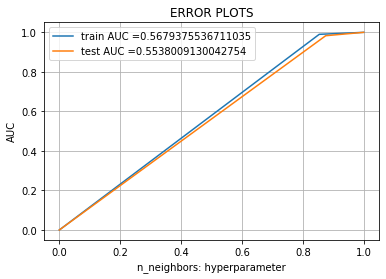

In [91]:
#Roc curve usign best KNN
from sklearn.metrics import roc_curve, auc


clf = KNeighborsClassifier(n_neighbors = 9)
clf.fit(X_bow_tr, y_bow_tr)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = clf.predict(X_bow_tr)    
y_test_pred = clf.predict(X_bow_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_bow_tr, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_bow_te, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("n_neighbors: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

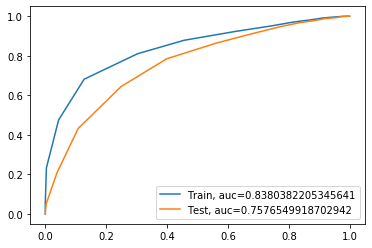

In [130]:
clf = KNeighborsClassifier(n_neighbors = 25)
clf.fit(X_bow_tr, y_bow_tr)

y_pred_tr = clf.predict_proba(X_bow_tr)[::,1]
y_pred_te = clf.predict_proba(X_bow_te)[::,1]
fpr_tr, tpr_tr, _tr = metrics.roc_curve(y_bow_tr,  y_pred_tr)
fpr_te, tpr_te, _te = metrics.roc_curve(y_bow_te,  y_pred_te)
auc_tr_bow_knn = metrics.roc_auc_score(y_bow_tr, y_pred_tr)
auc_te_bow_knn = metrics.roc_auc_score(y_bow_te, y_pred_te)
plt.plot(fpr_tr,tpr_tr,label="Train, auc="+str(auc_tr_bow_knn))
plt.plot(fpr_te,tpr_te,label="Test, auc="+str(auc_te_bow_knn))
plt.legend(loc=4)
plt.show()

In [24]:
#Manually searching for the best hyperparamter using Naive Bayes
from sklearn.metrics import accuracy_score
A = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
for a in tqdm(A):
    clf = MultinomialNB(alpha = a)
    clf.fit(X_bow_tr, y_bow_tr)
    
    y_pred_tr = clf.predict(X_bow_tr)
    y_pred_cv = clf.predict(X_bow_cv)
    
    tr_acc = accuracy_score(y_bow_tr, y_pred_tr)
    cv_acc = accuracy_score(y_bow_cv, y_pred_cv)
    
    print("The accuracy for value of alpha: " + str(a)+" is " +str(tr_acc)+" for train and " + str(cv_acc) +"for cv")

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

The accuracy for value of alpha: 0.0001 is 0.9936734693877551 for train and 0.9033333333333333for cv
The accuracy for value of alpha: 0.001 is 0.9928571428571429 for train and 0.9057142857142857for cv
The accuracy for value of alpha: 0.01 is 0.9914285714285714 for train and 0.9128571428571428for cv
The accuracy for value of alpha: 0.1 is 0.9842857142857143 for train and 0.9247619047619048for cv
The accuracy for value of alpha: 1 is 0.9563265306122449 for train and 0.9152380952380952for cv
The accuracy for value of alpha: 10 is 0.8883673469387755 for train and 0.8938095238095238for cv
The accuracy for value of alpha: 100 is 0.8881632653061224 for train and 0.8938095238095238for cv
The accuracy for value of alpha: 1000 is 0.8881632653061224 for train and 0.8938095238095238for cv
The accuracy for value of alpha: 10000 is 0.8881632653061224 for train and 0.8938095238095238for cv


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 134.69it/s]


In [92]:
#Hyperparameter tuning for Naive Bayes
from sklearn.model_selection import GridSearchCV
gsc = GridSearchCV(
        estimator = MultinomialNB(),
        param_grid = {
            'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
        }, cv = 3, scoring = 'roc_auc', verbose = 10)

grid_result = gsc.fit(X_bow_tr, y_bow_tr)
best_params = grid_result.best_params_
print(best_params)
print(gsc.score(X_bow_tr, y_bow_tr))
best_model = MultinomialNB(alpha = best_params['alpha'])

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] alpha=0.0001 ....................................................
[CV] ........................ alpha=0.0001, score=0.740, total=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] alpha=0.0001 ....................................................
[CV] ........................ alpha=0.0001, score=0.706, total=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] alpha=0.0001 ....................................................
[CV] ........................ alpha=0.0001, score=0.724, total=   0.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s


[CV] alpha=0.001 .....................................................
[CV] ......................... alpha=0.001, score=0.768, total=   0.0s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


[CV] alpha=0.001 .....................................................
[CV] ......................... alpha=0.001, score=0.747, total=   0.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s


[CV] alpha=0.001 .....................................................
[CV] ......................... alpha=0.001, score=0.767, total=   0.0s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s


[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.830, total=   0.0s


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s


[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.786, total=   0.0s


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s


[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.817, total=   0.0s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s


[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.889, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.863, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.860, total=   0.0s
[CV] alpha=1 .........................................................
[CV] ............................. alpha=1, score=0.816, total=   0.0s
[CV] alpha=1 .........................................................
[CV] ............................. alpha=1, score=0.811, total=   0.0s
[CV] alpha=1 .........................................................
[CV] ............................. alpha=1, score=0.815, total=   0.0s
[CV] alpha=10 ........................................................
[CV] ............................ alpha=10, score=0.614, total=   0.0s
[CV] a

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    0.1s finished


{'alpha': 0.1}
0.9973344749624302


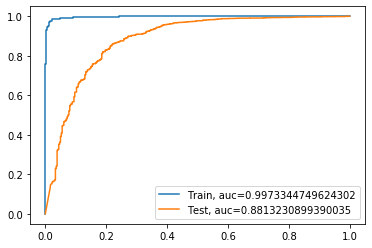

In [93]:
#Plotting the ROC-AUC curve using Naive Bayes
best_model.fit(X_bow_tr, y_bow_tr)

y_pred_tr = best_model.predict_proba(X_bow_tr)[::,1]
y_pred_te = best_model.predict_proba(X_bow_te)[::,1]
fpr_tr, tpr_tr, _tr = metrics.roc_curve(y_bow_tr,  y_pred_tr)
fpr_te, tpr_te, _te = metrics.roc_curve(y_bow_te,  y_pred_te)
auc_tr_bow_nb1 = metrics.roc_auc_score(y_bow_tr, y_pred_tr)
auc_te_bow_nb1 = metrics.roc_auc_score(y_bow_te, y_pred_te)
plt.plot(fpr_tr,tpr_tr,label="Train, auc="+str(auc_tr_bow_nb1))
plt.plot(fpr_te,tpr_te,label="Test, auc="+str(auc_te_bow_nb1))
plt.legend(loc=4)
plt.show()

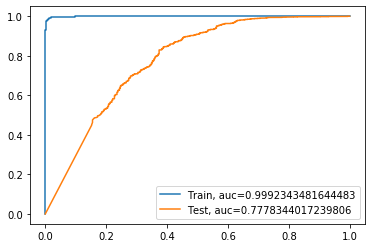

In [27]:
#Plotting the ROC-AUC curve using Naive Bayes
clf = MultinomialNB(alpha = 0.001)
clf.fit(X_bow_tr, y_bow_tr)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_pred_tr = clf.predict_proba(X_bow_tr)[::,1]
y_pred_te = clf.predict_proba(X_bow_te)[::,1]
fpr_tr, tpr_tr, _tr = metrics.roc_curve(y_bow_tr,  y_pred_tr)
fpr_te, tpr_te, _te = metrics.roc_curve(y_bow_te,  y_pred_te)
auc_tr_bow_nb2 = metrics.roc_auc_score(y_bow_tr, y_pred_tr)
auc_te_bow_nb2 = metrics.roc_auc_score(y_bow_te, y_pred_te)
plt.plot(fpr_tr,tpr_tr,label="Train, auc="+str(auc_tr_bow_nb2))
plt.plot(fpr_te,tpr_te,label="Test, auc="+str(auc_te_bow_nb2))
plt.legend(loc=4)
plt.show()

In [28]:
#Hyperparamter tuning for logistic regression
gsc = GridSearchCV(
    estimator = SGDClassifier(loss = 'log'), 
    param_grid = {
        'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
    }, cv = 5, scoring='neg_mean_squared_error', verbose=10, n_jobs=-1)

grid_result = gsc.fit(X_bow_tr, y_bow_tr)
best_params = grid_result.best_params_
print(best_params)
print(gsc.score(X_bow_tr, y_bow_tr))
best_model = SGDClassifier(loss = 'log', alpha = best_params['alpha'])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  27 out of  45 | elapsed:    3.2s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  32 out of  45 | elapsed:    3.2s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  37 out of  45 | elapsed:    3.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  42 out of  45 | elapsed:    3.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.3s finished


{'alpha': 0.001}
-0.010816326530612244


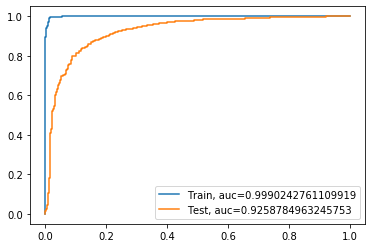

In [29]:
#Roc curve using logistic regression
#Code taken from https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python
best_model.fit(X_bow_tr, y_bow_tr)

y_pred_tr = best_model.predict_proba(X_bow_tr)[::,1]
y_pred_te = best_model.predict_proba(X_bow_te)[::,1]
fpr_tr, tpr_tr, _tr = metrics.roc_curve(y_bow_tr,  y_pred_tr)
fpr_te, tpr_te, _te = metrics.roc_curve(y_bow_te,  y_pred_te)
auc_tr_bow_lr = metrics.roc_auc_score(y_bow_tr, y_pred_tr)
auc_te_bow_lr = metrics.roc_auc_score(y_bow_te, y_pred_te)
plt.plot(fpr_tr,tpr_tr,label="Train, auc="+str(auc_tr_bow_lr))
plt.plot(fpr_te,tpr_te,label="Test, auc="+str(auc_te_bow_lr))
plt.legend(loc=4)
plt.show()

In [96]:
#Hpyerparamter tuning for SVM
gsc = GridSearchCV(
    estimator = SGDClassifier(loss = 'hinge'), 
    param_grid = {
        'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
    }, cv = 5, scoring='neg_mean_squared_error', verbose=10, n_jobs=-1)

grid_result = gsc.fit(X_bow_tr, y_bow_tr)
best_params = grid_result.best_params_
print(best_params)
print(gsc.score(X_bow_tr, y_bow_tr))
best_model = SGDClassifier(loss = 'hinge', alpha = best_params['alpha'])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0479s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done   7 out of  45 | elapsed:    0.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  12 out of  45 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  22 out of  45 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  37 out of  45 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.2s finished


{'alpha': 0.001}
-0.0020408163265306124


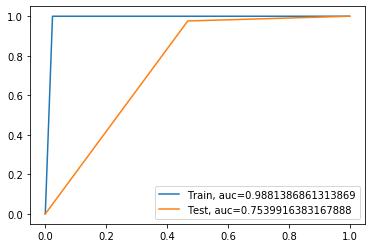

In [97]:
#Roc curve using SVM
#Code taken from https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python
best_model.fit(X_bow_tr, y_bow_tr)

y_pred_tr = best_model.predict(X_bow_tr)
y_pred_te = best_model.predict(X_bow_te)
fpr_tr, tpr_tr, _tr = metrics.roc_curve(y_bow_tr,  y_pred_tr)
fpr_te, tpr_te, _te = metrics.roc_curve(y_bow_te,  y_pred_te)
auc_tr_bow_svm = metrics.roc_auc_score(y_bow_tr, y_pred_tr)
auc_te_bow_svm = metrics.roc_auc_score(y_bow_te, y_pred_te)
plt.plot(fpr_tr,tpr_tr,label="Train, auc="+str(auc_tr_bow_svm))
plt.plot(fpr_te,tpr_te,label="Test, auc="+str(auc_te_bow_svm))
plt.legend(loc=4)
plt.show()

In [32]:
#Hyperparamter tuning for Decision trees
D = [2, 5, 10, 20, 50]
MSS = [5, 10, 20, 30, 50, 100]
for d in tqdm(D):
    for m in MSS:
        clf = DecisionTreeClassifier(max_depth = d, min_samples_split = m)
        clf.fit(X_bow_tr, y_bow_tr)

        y_pred_tr = clf.predict(X_bow_tr)
        y_pred_cv = clf.predict(X_bow_cv)

        tr_acc = accuracy_score(y_bow_tr, y_pred_tr)
        cv_acc = accuracy_score(y_bow_cv, y_pred_cv)
    
        print("The accuracy for value of depth: " + str(d)+" and min samples split: " + str(m) +" is " +str(tr_acc)+" for train and " + str(cv_acc) +"for cv")

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

The accuracy for value of depth: 2 and min samples split: 5 is 0.8914285714285715 for train and 0.8942857142857142for cv
The accuracy for value of depth: 2 and min samples split: 10 is 0.8914285714285715 for train and 0.8942857142857142for cv
The accuracy for value of depth: 2 and min samples split: 20 is 0.8914285714285715 for train and 0.8942857142857142for cv
The accuracy for value of depth: 2 and min samples split: 30 is 0.8914285714285715 for train and 0.8942857142857142for cv
The accuracy for value of depth: 2 and min samples split: 50 is 0.8914285714285715 for train and 0.8942857142857142for cv
The accuracy for value of depth: 2 and min samples split: 100 is 0.8914285714285715 for train and 0.8942857142857142for cv


 20%|████████████████▊                                                                   | 1/5 [00:00<00:00,  5.45it/s]

The accuracy for value of depth: 5 and min samples split: 5 is 0.9038775510204081 for train and 0.9052380952380953for cv
The accuracy for value of depth: 5 and min samples split: 10 is 0.9040816326530612 for train and 0.9052380952380953for cv
The accuracy for value of depth: 5 and min samples split: 20 is 0.9026530612244898 for train and 0.9042857142857142for cv
The accuracy for value of depth: 5 and min samples split: 30 is 0.9026530612244898 for train and 0.9047619047619048for cv
The accuracy for value of depth: 5 and min samples split: 50 is 0.9018367346938776 for train and 0.9047619047619048for cv
The accuracy for value of depth: 5 and min samples split: 100 is 0.9018367346938776 for train and 0.9047619047619048for cv


 40%|█████████████████████████████████▌                                                  | 2/5 [00:00<00:00,  4.82it/s]

The accuracy for value of depth: 10 and min samples split: 5 is 0.9179591836734694 for train and 0.910952380952381for cv
The accuracy for value of depth: 10 and min samples split: 10 is 0.9177551020408163 for train and 0.9119047619047619for cv
The accuracy for value of depth: 10 and min samples split: 20 is 0.9155102040816326 for train and 0.9080952380952381for cv
The accuracy for value of depth: 10 and min samples split: 30 is 0.9142857142857143 for train and 0.91for cv
The accuracy for value of depth: 10 and min samples split: 50 is 0.9140816326530612 for train and 0.9095238095238095for cv
The accuracy for value of depth: 10 and min samples split: 100 is 0.9138775510204081 for train and 0.910952380952381for cv


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:00<00:00,  3.81it/s]

The accuracy for value of depth: 20 and min samples split: 5 is 0.9391836734693878 for train and 0.9095238095238095for cv
The accuracy for value of depth: 20 and min samples split: 10 is 0.9369387755102041 for train and 0.91for cv
The accuracy for value of depth: 20 and min samples split: 20 is 0.9310204081632653 for train and 0.9095238095238095for cv
The accuracy for value of depth: 20 and min samples split: 30 is 0.9277551020408163 for train and 0.9085714285714286for cv
The accuracy for value of depth: 20 and min samples split: 50 is 0.9257142857142857 for train and 0.909047619047619for cv
The accuracy for value of depth: 20 and min samples split: 100 is 0.9259183673469388 for train and 0.909047619047619for cv


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:01<00:00,  2.62it/s]

The accuracy for value of depth: 50 and min samples split: 5 is 0.9677551020408163 for train and 0.9014285714285715for cv
The accuracy for value of depth: 50 and min samples split: 10 is 0.9628571428571429 for train and 0.9061904761904762for cv
The accuracy for value of depth: 50 and min samples split: 20 is 0.9528571428571428 for train and 0.9066666666666666for cv
The accuracy for value of depth: 50 and min samples split: 30 is 0.9469387755102041 for train and 0.9066666666666666for cv
The accuracy for value of depth: 50 and min samples split: 50 is 0.9430612244897959 for train and 0.9095238095238095for cv
The accuracy for value of depth: 50 and min samples split: 100 is 0.9408163265306122 for train and 0.9095238095238095for cv


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.40it/s]


In [21]:
gsc = GridSearchCV(
    estimator = DecisionTreeClassifier(), 
    param_grid = {
        'max_depth': [2, 5, 10, 20, 50],
        'min_samples_split': [5, 10, 20, 30, 50, 100]
    }, cv = 5, scoring='roc_auc', verbose=10, n_jobs=-1)

grid_result = gsc.fit(X_bow_tr, y_bow_tr)
best_params = grid_result.best_params_
print(best_params)
print(gsc.score(X_bow_tr, y_bow_tr))
best_model = DecisionTreeClassifier(max_depth = best_params['max_depth'], min_samples_split = best_params['min_samples_split'])

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 143 out of 150 | elapsed:    5.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    5.6s finished


{'max_depth': 50, 'min_samples_split': 100}
0.903440524968664


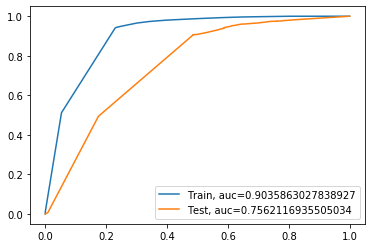

In [22]:
#Plotting the ROC curve for Decision Tree
best_model.fit(X_bow_tr, y_bow_tr)

y_pred_tr = best_model.predict_proba(X_bow_tr)[::,1]
y_pred_te = best_model.predict_proba(X_bow_te)[::,1]
fpr_tr, tpr_tr, _tr = metrics.roc_curve(y_bow_tr,  y_pred_tr)
fpr_te, tpr_te, _te = metrics.roc_curve(y_bow_te,  y_pred_te)
auc_tr_bow_dt = metrics.roc_auc_score(y_bow_tr, y_pred_tr)
auc_te_bow_dt = metrics.roc_auc_score(y_bow_te, y_pred_te)
plt.plot(fpr_tr,tpr_tr,label="Train, auc="+str(auc_tr_bow_dt))
plt.plot(fpr_te,tpr_te,label="Test, auc="+str(auc_te_bow_dt))
plt.legend(loc=4)
plt.show()

# 2 TF-IDF vectors

In [54]:
tfidfv = TfidfVectorizer(ngram_range = (1, 4), min_df = 10, max_features = 10000)
reviews_tfidf = tfidfv.fit_transform(preprocessed_reviews)
summaries_tfidf = tfidfv.fit_transform(preprocessed_summaries)
print(reviews_tfidf.shape)
print(summaries_tfidf.shape)

(364171, 10000)
(364171, 10000)


In [55]:
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
X_tfidf = hstack((reviews_tfidf, summaries_tfidf)).tocsr()
X_tfidf = X_tfidf[:10000]
Y = Y[:10000]
print(Y.value_counts())
X_tfidf_1, X_tfidf_te, y_tfidf_1, y_tfidf_te = train_test_split(X_tfidf, Y, test_size = 0.3, random_state = 0)
X_tfidf_tr, X_tfidf_cv, y_tfidf_tr, y_tfidf_cv = train_test_split(X_tfidf_1, y_tfidf_1, test_size=0.3)

1    8868
0    1132
Name: Score, dtype: int64


In [ ]:
#Hyperparamter tuning for KNN
gsc = GridSearchCV(
        estimator = KNeighborsClassifier(),
        param_grid = {
            'n_neighbors': [1, 3, 5, 9, 13, 19, 25, 35, 50]
        }, cv = 3, scoring = 'roc_auc', verbose = 10)

grid_result = gsc.fit(X_tfidf_tr, y_tfidf_tr)
best_params = grid_result.best_params_
print(best_params)
print(gsc.score(X_tfidf_tr, y_tfidf_tr))
best_model = KNeighborsClassifier(n_neighbors = best_params['n_neighbors'])

In [ ]:
#Plotting the ROC curve for KNN
best_model.fit(X_bow_tr, y_bow_tr)

y_pred_tr = best_model.predict_proba(X_bow_tr)[::,1]
y_pred_te = best_model.predict_proba(X_bow_te)[::,1]
fpr_tr, tpr_tr, _tr = metrics.roc_curve(y_bow_tr,  y_pred_tr)
fpr_te, tpr_te, _te = metrics.roc_curve(y_bow_te,  y_pred_te)
auc_tr_tfidf_knn = metrics.roc_auc_score(y_bow_tr, y_pred_tr)
auc_te_tfidf_knn = metrics.roc_auc_score(y_bow_te, y_pred_te)
plt.plot(fpr_tr,tpr_tr,label="Train, auc="+str(auc_tr_tfidf_knn))
plt.plot(fpr_te,tpr_te,label="Test, auc="+str(auc_te_tfidf_knn))
plt.legend(loc=4)
plt.show()

In [26]:
#Hyperparameter tuning for Naive Bayes
from sklearn.model_selection import GridSearchCV
gsc = GridSearchCV(
        estimator = MultinomialNB(),
        param_grid = {
            'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
        }, cv = 3, scoring = 'neg_mean_squared_error', verbose = 10)

grid_result = gsc.fit(X_tfidf_tr, y_tfidf_tr)
best_params = grid_result.best_params_
print(best_params)
print(gsc.score(X_tfidf_tr, y_tfidf_tr))
best_model = MultinomialNB(alpha = best_params['alpha'])

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] alpha=0.0001 ....................................................
[CV] ....................... alpha=0.0001, score=-0.082, total=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] alpha=0.0001 ....................................................
[CV] ....................... alpha=0.0001, score=-0.084, total=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] alpha=0.0001 ....................................................
[CV] ....................... alpha=0.0001, score=-0.092, total=   0.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s


[CV] alpha=0.001 .....................................................
[CV] ........................ alpha=0.001, score=-0.080, total=   0.0s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


[CV] alpha=0.001 .....................................................
[CV] ........................ alpha=0.001, score=-0.081, total=   0.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s


[CV] alpha=0.001 .....................................................
[CV] ........................ alpha=0.001, score=-0.088, total=   0.0s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s


[CV] alpha=0.01 ......................................................
[CV] ......................... alpha=0.01, score=-0.073, total=   0.0s


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s


[CV] alpha=0.01 ......................................................
[CV] ......................... alpha=0.01, score=-0.076, total=   0.0s


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s


[CV] alpha=0.01 ......................................................
[CV] ......................... alpha=0.01, score=-0.082, total=   0.0s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s


[CV] alpha=0.1 .......................................................
[CV] .......................... alpha=0.1, score=-0.073, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] .......................... alpha=0.1, score=-0.075, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] .......................... alpha=0.1, score=-0.080, total=   0.0s
[CV] alpha=1 .........................................................
[CV] ............................ alpha=1, score=-0.111, total=   0.0s
[CV] alpha=1 .........................................................
[CV] ............................ alpha=1, score=-0.109, total=   0.0s
[CV] alpha=1 .........................................................
[CV] ............................ alpha=1, score=-0.110, total=   0.0s
[CV] alpha=10 ........................................................
[CV] ........................... alpha=10, score=-0.111, total=   0.0s
[CV] a

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    0.2s finished


{'alpha': 0.1}
-0.01020408163265306


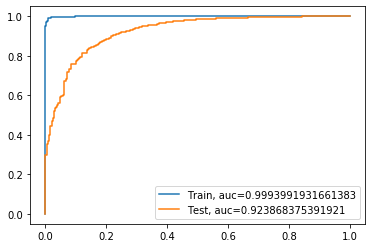

In [27]:
#Plotting the ROC curve for Niave Bayes
best_model.fit(X_tfidf_tr, y_tfidf_tr)

y_pred_tr = best_model.predict_proba(X_tfidf_tr)[::,1]
y_pred_te = best_model.predict_proba(X_tfidf_te)[::,1]
fpr_tr, tpr_tr, _tr = metrics.roc_curve(y_tfidf_tr,  y_pred_tr)
fpr_te, tpr_te, _te = metrics.roc_curve(y_tfidf_te,  y_pred_te)
auc_tr_tfidf_nb = metrics.roc_auc_score(y_tfidf_tr, y_pred_tr)
auc_te_tfidf_nb = metrics.roc_auc_score(y_tfidf_te, y_pred_te)
plt.plot(fpr_tr,tpr_tr,label="Train, auc="+str(auc_tr_tfidf_nb))
plt.plot(fpr_te,tpr_te,label="Test, auc="+str(auc_te_tfidf_nb))
plt.legend(loc=4)
plt.show()

In [ ]:
#Hyperparamter tuning for logistic regression
gsc = GridSearchCV(
    estimator = SGDClassifier(loss = 'log'), 
    param_grid = {
        'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
    }, cv = 5, scoring='roc_auc', verbose=10, n_jobs=-1)

grid_result = gsc.fit(X_tfidf_tr, y_tfidf_tr)
best_params = grid_result.best_params_
print(best_params)
print(gsc.score(X_tfidf_tr, y_tfidf_tr))
best_model = SGDClassifier(loss = 'log', alpha = best_params['alpha'])

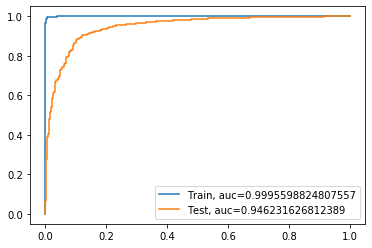

In [133]:
#Roc curve using logistic regression
#Code taken from https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python
best_model.fit(X_tfidf_tr, y_tfidf_tr)

y_pred_tr = best_model.predict_proba(X_tfidf_tr)[::,1]
y_pred_te = best_model.predict_proba(X_tfidf_te)[::,1]
fpr_tr, tpr_tr, _tr = metrics.roc_curve(y_tfidf_tr,  y_pred_tr)
fpr_te, tpr_te, _te = metrics.roc_curve(y_tfidf_te,  y_pred_te)
auc_tr_tfidf_lr = metrics.roc_auc_score(y_tfidf_tr, y_pred_tr)
auc_te_tfidf_lr = metrics.roc_auc_score(y_tfidf_te, y_pred_te)
plt.plot(fpr_tr,tpr_tr,label="Train, auc="+str(auc_tr_tfidf_lr))
plt.plot(fpr_te,tpr_te,label="Test, auc="+str(auc_te_tfidf_lr))
plt.legend(loc=4)
plt.show()

In [104]:
#Hpyerparamter tuning for SVM
gsc = GridSearchCV(
    estimator = SGDClassifier(loss = 'hinge'), 
    param_grid = {
        'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
    }, cv = 5, scoring='neg_mean_squared_error', verbose=10, n_jobs=-1)

grid_result = gsc.fit(X_tfidf_tr, y_tfidf_tr)
best_params = grid_result.best_params_
print(best_params)
print(gsc.score(X_tfidf_tr, y_tfidf_tr))
best_model = SGDClassifier(loss = 'hinge', alpha = best_params['alpha'])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0439s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done   7 out of  45 | elapsed:    0.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  12 out of  45 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  17 out of  45 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  22 out of  45 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  37 out of  45 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.2s finished


{'alpha': 0.0001}
-0.00040816326530612246


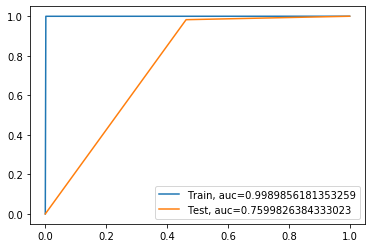

In [105]:
#Roc curve using SVM
#Code taken from https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python
best_model.fit(X_tfidf_tr, y_tfidf_tr)

y_pred_tr = best_model.predict(X_tfidf_tr)
y_pred_te = best_model.predict(X_tfidf_te)
fpr_tr, tpr_tr, _tr = metrics.roc_curve(y_tfidf_tr,  y_pred_tr)
fpr_te, tpr_te, _te = metrics.roc_curve(y_tfidf_te,  y_pred_te)
auc_tr_tfidf_svm = metrics.roc_auc_score(y_tfidf_tr, y_pred_tr)
auc_te_tfidf_svm = metrics.roc_auc_score(y_tfidf_te, y_pred_te)
plt.plot(fpr_tr,tpr_tr,label="Train, auc="+str(auc_tr_tfidf_svm))
plt.plot(fpr_te,tpr_te,label="Test, auc="+str(auc_te_tfidf_svm))
plt.legend(loc=4)
plt.show()

In [45]:
#Hyperparamter tuning for Decision trees
D = [2, 5, 10, 20, 50]
MSS = [5, 10, 20, 30, 50, 100]
for d in tqdm(D):
    for m in MSS:
        clf = DecisionTreeClassifier(max_depth = d, min_samples_split = m)
        clf.fit(X_tfidf_tr, y_tfidf_tr)

        y_pred_tr = clf.predict(X_tfidf_tr)
        y_pred_cv = clf.predict(X_tfidf_cv)

        tr_acc = accuracy_score(y_tfidf_tr, y_tfidf_tr)
        cv_acc = accuracy_score(y_tfidf_cv, y_tfidf_cv)
    
        print("The accuracy for value of depth: " + str(d)+" and min samples split: " + str(m) +" is " +str(tr_acc)+" for train and " + str(cv_acc) +" for cv")

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

The accuracy for value of depth: 2 and min samples split: 5 is 1.0 for train and 1.0 for cv
The accuracy for value of depth: 2 and min samples split: 10 is 1.0 for train and 1.0 for cv
The accuracy for value of depth: 2 and min samples split: 20 is 1.0 for train and 1.0 for cv
The accuracy for value of depth: 2 and min samples split: 30 is 1.0 for train and 1.0 for cv
The accuracy for value of depth: 2 and min samples split: 50 is 1.0 for train and 1.0 for cv
The accuracy for value of depth: 2 and min samples split: 100 is 1.0 for train and 1.0 for cv


 20%|████████████████▊                                                                   | 1/5 [00:00<00:01,  3.45it/s]

The accuracy for value of depth: 5 and min samples split: 5 is 1.0 for train and 1.0 for cv
The accuracy for value of depth: 5 and min samples split: 10 is 1.0 for train and 1.0 for cv
The accuracy for value of depth: 5 and min samples split: 20 is 1.0 for train and 1.0 for cv
The accuracy for value of depth: 5 and min samples split: 30 is 1.0 for train and 1.0 for cv
The accuracy for value of depth: 5 and min samples split: 50 is 1.0 for train and 1.0 for cv
The accuracy for value of depth: 5 and min samples split: 100 is 1.0 for train and 1.0 for cv


 40%|█████████████████████████████████▌                                                  | 2/5 [00:00<00:01,  2.71it/s]

The accuracy for value of depth: 10 and min samples split: 5 is 1.0 for train and 1.0 for cv
The accuracy for value of depth: 10 and min samples split: 10 is 1.0 for train and 1.0 for cv
The accuracy for value of depth: 10 and min samples split: 20 is 1.0 for train and 1.0 for cv
The accuracy for value of depth: 10 and min samples split: 30 is 1.0 for train and 1.0 for cv
The accuracy for value of depth: 10 and min samples split: 50 is 1.0 for train and 1.0 for cv
The accuracy for value of depth: 10 and min samples split: 100 is 1.0 for train and 1.0 for cv


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:01<00:01,  1.81it/s]

The accuracy for value of depth: 20 and min samples split: 5 is 1.0 for train and 1.0 for cv
The accuracy for value of depth: 20 and min samples split: 10 is 1.0 for train and 1.0 for cv
The accuracy for value of depth: 20 and min samples split: 20 is 1.0 for train and 1.0 for cv
The accuracy for value of depth: 20 and min samples split: 30 is 1.0 for train and 1.0 for cv
The accuracy for value of depth: 20 and min samples split: 50 is 1.0 for train and 1.0 for cv
The accuracy for value of depth: 20 and min samples split: 100 is 1.0 for train and 1.0 for cv


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:03<00:00,  1.05it/s]

The accuracy for value of depth: 50 and min samples split: 5 is 1.0 for train and 1.0 for cv
The accuracy for value of depth: 50 and min samples split: 10 is 1.0 for train and 1.0 for cv
The accuracy for value of depth: 50 and min samples split: 20 is 1.0 for train and 1.0 for cv
The accuracy for value of depth: 50 and min samples split: 30 is 1.0 for train and 1.0 for cv
The accuracy for value of depth: 50 and min samples split: 50 is 1.0 for train and 1.0 for cv
The accuracy for value of depth: 50 and min samples split: 100 is 1.0 for train and 1.0 for cv


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.88s/it]


In [57]:
#Hyperparamter tuning with decision trees
gsc = GridSearchCV(
    estimator = DecisionTreeClassifier(), 
    param_grid = {
        'max_depth': [2, 5, 10, 20, 50],
        'min_samples_split': [5, 10, 20, 30, 50, 100]
    }, cv = 5, scoring='neg_mean_squared_error', verbose=10, n_jobs=-1)

grid_result = gsc.fit(X_tfidf_tr, y_tfidf_tr)
best_params = grid_result.best_params_
print(best_params)
print(gsc.score(X_tfidf_tr, y_tfidf_tr))
best_model = DecisionTreeClassifier(max_depth = best_params['max_depth'], min_samples_split = best_params['min_samples_split'])

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 143 out of 150 | elapsed:    8.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    9.2s finished


{'max_depth': 10, 'min_samples_split': 100}
-0.0810204081632653


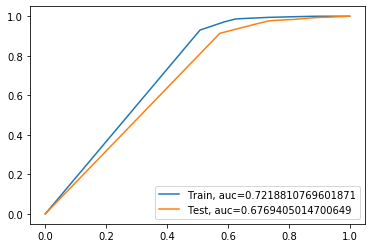

In [58]:
#Plotting the ROC curve for Decision Tree
best_model.fit(X_tfidf_tr, y_tfidf_tr)

y_pred_tr = best_model.predict_proba(X_tfidf_tr)[::,1]
y_pred_te = best_model.predict_proba(X_tfidf_te)[::,1]
fpr_tr, tpr_tr, _tr = metrics.roc_curve(y_tfidf_tr,  y_pred_tr)
fpr_te, tpr_te, _te = metrics.roc_curve(y_tfidf_te,  y_pred_te)
auc_tr_tfidf_dt = metrics.roc_auc_score(y_tfidf_tr, y_pred_tr)
auc_te_tfidf_dt = metrics.roc_auc_score(y_tfidf_te, y_pred_te)
plt.plot(fpr_tr,tpr_tr,label="Train, auc="+str(auc_tr_tfidf_dt))
plt.plot(fpr_te,tpr_te,label="Test, auc="+str(auc_te_tfidf_dt))
plt.legend(loc=4)
plt.show()

# 3. Average Word2Vec

In [28]:
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews[:10000]:
#for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [29]:
i = 0
summary_list = []
for summ in preprocessed_summaries[0:10000]:
#for summ in preprocessed_summaries:
    summary_list.append(summ.split())

In [30]:
if os.path.isfile('GoogleNews-vectors-negative300.bin'):
    w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
    print(w2v_model.wv.most_similar('great'))
    print(w2v_model.wv.most_similar('worst'))
else:
    print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('terrific', 0.7989331483840942), ('fantastic', 0.7935211658477783), ('tremendous', 0.7748856544494629), ('wonderful', 0.7647868394851685), ('good', 0.7291510105133057), ('incredible', 0.7032873630523682), ('marvelous', 0.6971102952957153), ('phenomenal', 0.6841565370559692), ('amazing', 0.6634128093719482), ('awesome', 0.6510506868362427)]
[('Worst', 0.6146092414855957), ('weakest', 0.6143776774406433), ('scariest', 0.5957258343696594), ('ugliest', 0.5931180715560913), ('best', 0.5835110545158386), ('bleakest', 0.5718506574630737), ('strongest', 0.567145586013794), ('nastiest', 0.5644308924674988), ('lousiest', 0.5631451606750488), ('toughest', 0.5624395608901978)]


In [31]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3000000
sample words  ['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said', 'was', 'the', 'at', 'not', 'as', 'it', 'be', 'from', 'by', 'are', 'I', 'have', 'he', 'will', 'has', '####', 'his', 'an', 'this', 'or', 'their', 'who', 'they', 'but', '$', 'had', 'year', 'were', 'we', 'more', '###', 'up', 'been', 'you', 'its', 'one', 'about', 'would', 'which', 'out']


In [32]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [13:06<00:00, 12.72it/s]


10000
300


In [33]:
sum_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for summ in tqdm(summary_list): # for each review/sentence
    summ_v = np.zeros(300) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in summ: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            summ_v += vec
            cnt_words += 1
    if cnt_words != 0:
        summ_v /= cnt_words
    sum_vectors.append(summ_v)
print(len(sum_vectors))
print(len(sum_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:21<00:00, 122.98it/s]


10000
300


In [36]:
sev = np.asarray(sent_vectors)
suv = np.asarray(sum_vectors)
print(sev.shape, suv.shape)

(10000, 300) (10000, 300)


In [37]:
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
y = Y[:10000]
print(y.value_counts())
X_aw2v = (np.vstack((sev.T, suv.T))).T
print(X_aw2v.shape)
X_aw2v_1, X_aw2v_te, y_aw2v_1, y_aw2v_te = train_test_split(X_aw2v, y, test_size = 0.3, random_state = 0)
X_aw2v_tr, X_aw2v_cv, y_aw2v_tr, y_aw2v_cv = train_test_split(X_aw2v_1, y_aw2v_1, test_size = 0.3, random_state = 0)

1    8868
0    1132
Name: Score, dtype: int64
(10000, 600)


In [107]:
#Hyperparamter tuning for KNN
from sklearn.model_selection import GridSearchCV
gsc = GridSearchCV(
        estimator = KNeighborsClassifier(),
        param_grid = {
            'n_neighbors': [1, 3, 5, 9, 13, 19, 25, 35, 50]
        }, cv = 3, scoring = 'roc_auc', verbose = 10)

grid_result = gsc.fit(X_aw2v_tr, y_aw2v_tr)
best_params = grid_result.best_params_
print(best_params)
print(gsc.score(X_aw2v_tr, y_aw2v_tr))
best_model = KNeighborsClassifier(n_neighbors = best_params['n_neighbors'])

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] n_neighbors=1 ...................................................
[CV] ....................... n_neighbors=1, score=0.631, total=   4.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s


[CV] n_neighbors=1 ...................................................
[CV] ....................... n_neighbors=1, score=0.697, total=   4.7s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.3s remaining:    0.0s


[CV] n_neighbors=1 ...................................................
[CV] ....................... n_neighbors=1, score=0.641, total=   4.7s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.9s remaining:    0.0s


[CV] n_neighbors=3 ...................................................
[CV] ....................... n_neighbors=3, score=0.708, total=   4.8s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   18.8s remaining:    0.0s


[CV] n_neighbors=3 ...................................................
[CV] ....................... n_neighbors=3, score=0.780, total=   4.7s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.5s remaining:    0.0s


[CV] n_neighbors=3 ...................................................
[CV] ....................... n_neighbors=3, score=0.750, total=   4.7s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   28.2s remaining:    0.0s


[CV] n_neighbors=5 ...................................................
[CV] ....................... n_neighbors=5, score=0.724, total=   4.7s


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   32.9s remaining:    0.0s


[CV] n_neighbors=5 ...................................................
[CV] ....................... n_neighbors=5, score=0.800, total=   4.7s


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   37.7s remaining:    0.0s


[CV] n_neighbors=5 ...................................................
[CV] ....................... n_neighbors=5, score=0.764, total=   4.7s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   42.4s remaining:    0.0s


[CV] n_neighbors=9 ...................................................
[CV] ....................... n_neighbors=9, score=0.746, total=   4.7s
[CV] n_neighbors=9 ...................................................
[CV] ....................... n_neighbors=9, score=0.837, total=   4.8s
[CV] n_neighbors=9 ...................................................
[CV] ....................... n_neighbors=9, score=0.779, total=   4.7s
[CV] n_neighbors=13 ..................................................
[CV] ...................... n_neighbors=13, score=0.761, total=   4.9s
[CV] n_neighbors=13 ..................................................
[CV] ...................... n_neighbors=13, score=0.847, total=   4.8s
[CV] n_neighbors=13 ..................................................
[CV] ...................... n_neighbors=13, score=0.803, total=   4.8s
[CV] n_neighbors=19 ..................................................
[CV] ...................... n_neighbors=19, score=0.781, total=   4.9s
[CV] n

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  2.1min finished


{'n_neighbors': 50}
0.9014143882668988


In [108]:
#Manually searching for the best hyperparameter using KNN
from sklearn.metrics import accuracy_score
ks = [1, 3, 5, 9, 13, 19, 25, 35, 50]
for k in tqdm(ks):
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(X_aw2v_tr, y_aw2v_tr)
    
    y_pred_tr = clf.predict(X_aw2v_tr)
    y_pred_cv = clf.predict(X_aw2v_cv)
    
    tr_acc = accuracy_score(y_aw2v_tr, y_pred_tr)
    cv_acc = accuracy_score(y_aw2v_cv, y_pred_cv)
    
    print("The accuracy for" + str(k) + "nearest neighbors is:" +str(tr_acc)+"for train and" + str(cv_acc) +"for cv")

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

The accuracy for1nearest neighbors is:1.0for train and0.8885714285714286for cv


 11%|█████████▎                                                                          | 1/9 [00:10<01:24, 10.55s/it]

The accuracy for3nearest neighbors is:0.9344897959183673for train and0.909047619047619for cv


 22%|██████████████████▋                                                                 | 2/9 [00:43<02:01, 17.34s/it]

The accuracy for5nearest neighbors is:0.9240816326530612for train and0.9152380952380952for cv


 33%|████████████████████████████                                                        | 3/9 [01:17<02:12, 22.15s/it]

The accuracy for9nearest neighbors is:0.9126530612244897for train and0.9133333333333333for cv


 44%|█████████████████████████████████████▎                                              | 4/9 [01:50<02:08, 25.63s/it]

The accuracy for13nearest neighbors is:0.9069387755102041for train and0.9095238095238095for cv


 56%|██████████████████████████████████████████████▋                                     | 5/9 [02:24<01:52, 28.04s/it]

The accuracy for19nearest neighbors is:0.9004081632653061for train and0.9066666666666666for cv


 67%|████████████████████████████████████████████████████████                            | 6/9 [02:58<01:29, 29.78s/it]

The accuracy for25nearest neighbors is:0.8975510204081633for train and0.9028571428571428for cv


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [03:32<01:02, 31.12s/it]

The accuracy for35nearest neighbors is:0.8944897959183673for train and0.900952380952381for cv


 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [04:06<00:31, 32.00s/it]

The accuracy for50nearest neighbors is:0.8922448979591837for train and0.9004761904761904for cv


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [04:40<00:00, 32.69s/it]


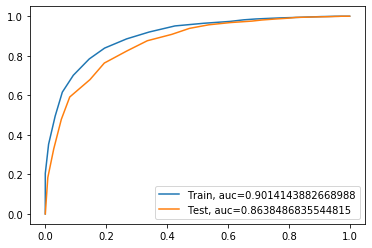

In [110]:
#Plotting the ROC curve for KNN
best_model.fit(X_aw2v_tr, y_aw2v_tr)

y_pred_tr = best_model.predict_proba(X_aw2v_tr)[::,1]
y_pred_te = best_model.predict_proba(X_aw2v_te)[::,1]
fpr_tr, tpr_tr, _tr = metrics.roc_curve(y_aw2v_tr,  y_pred_tr)
fpr_te, tpr_te, _te = metrics.roc_curve(y_aw2v_te,  y_pred_te)
auc_tr_aw_knn = metrics.roc_auc_score(y_aw2v_tr, y_pred_tr)
auc_te_aw_knn = metrics.roc_auc_score(y_aw2v_te, y_pred_te)
plt.plot(fpr_tr,tpr_tr,label="Train, auc="+str(auc_tr_aw_knn))
plt.plot(fpr_te,tpr_te,label="Test, auc="+str(auc_te_aw_knn))
plt.legend(loc=4)
plt.show()

In [59]:
#Application of Naive Bayes
from sklearn.metrics import accuracy_score
A = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
for a in A:
    clf = MultinomialNB(alpha = a)
    clf.fit(X_aw2v_tr, y_aw2v_tr)
    
    y_pred_tr = clf.predict(X_aw2v_tr)
    y_pred_cv = clf.predict(X_aw2v_cv)
    
    tr_acc = accuracy_score(y_aw2v_tr, y_pred_tr)
    cv_acc = accuracy_score(y_aw2v_cv, y_pred_cv)
    
    print("The accuracy for value of alpha: " + str(a)+" is " +str(tr_acc)+" for train and " + str(cv_acc) +"for cv")

ValueError: Input X must be non-negative

In [60]:
#Hyperparameter tuning for Naive Bayes
gsc = GridSearchCV(
        estimator = MultinomialNB(),
        param_grid = {
            'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
        }, cv = 3, scoring = 'neg_mean_squared error', verbose = 10)

grid_result = gsc.fit(X_aw2v_tr, y_aw2v_tr)
best_params = grid_result.best_params_
print(best_params)
print(gsc.score(X_aw2v_tr, y_aw2v_tr))
best_model = MultinomialNB(alpha = best_params['alpha'])

ValueError: 'neg_mean_squared error' is not a valid scoring value. Use sorted(sklearn.metrics.SCORERS.keys()) to get valid options.

In [61]:
#Hyperparamter tuning for logistic regression
gsc = GridSearchCV(
    estimator = SGDClassifier(loss = 'log'), 
    param_grid = {
        'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
    }, cv = 5, scoring='neg_mean_squared_error', verbose=10, n_jobs=-1)

grid_result = gsc.fit(X_aw2v_tr, y_aw2v_tr)
best_params = grid_result.best_params_
print(best_params)
print(gsc.score(X_aw2v_tr, y_aw2v_tr))
best_model = SGDClassifier(loss = 'log', alpha = best_params['alpha'])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  27 out of  45 | elapsed:    3.2s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  32 out of  45 | elapsed:    3.3s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  37 out of  45 | elapsed:    3.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  42 out of  45 | elapsed:    3.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.5s finished


{'alpha': 0.0001}
-0.044489795918367346


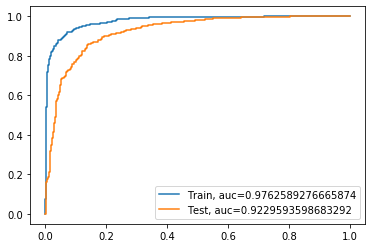

In [62]:
#Roc curve using logistic regression
#Code taken from https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python
best_model.fit(X_aw2v_tr, y_aw2v_tr)

y_pred_tr = best_model.predict_proba(X_aw2v_tr)[::,1]
y_pred_te = best_model.predict_proba(X_aw2v_te)[::,1]
fpr_tr, tpr_tr, _tr = metrics.roc_curve(y_aw2v_tr,  y_pred_tr)
fpr_te, tpr_te, _te = metrics.roc_curve(y_aw2v_te,  y_pred_te)
auc_tr_aw_lr = metrics.roc_auc_score(y_aw2v_tr, y_pred_tr)
auc_te_aw_lr = metrics.roc_auc_score(y_aw2v_te, y_pred_te)
plt.plot(fpr_tr,tpr_tr,label="Train, auc="+str(auc_tr_aw_lr))
plt.plot(fpr_te,tpr_te,label="Test, auc="+str(auc_te_aw_lr))
plt.legend(loc=4)
plt.show()

In [38]:
#Hpyerparamter tuning for SVM
gsc = GridSearchCV(
    estimator = SGDClassifier(loss = 'hinge'), 
    param_grid = {
        'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
    }, cv = 5, scoring='neg_mean_squared_error', verbose=10, n_jobs=-1)

grid_result = gsc.fit(X_aw2v_tr, y_aw2v_tr)
best_params = grid_result.best_params_
print(best_params)
print(gsc.score(X_aw2v_tr, y_aw2v_tr))
best_model = SGDClassifier(loss = 'hinge', alpha = best_params['alpha'])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  27 out of  45 | elapsed:    4.0s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  32 out of  45 | elapsed:    4.1s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  37 out of  45 | elapsed:    4.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  42 out of  45 | elapsed:    4.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    4.2s finished


{'alpha': 0.001}
-0.06489795918367347


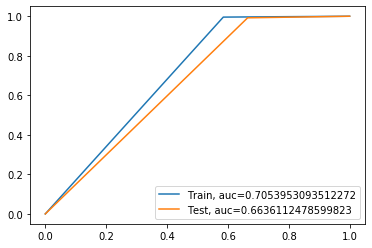

In [41]:
#Roc curve using SVM
#Code taken from https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python
best_model.fit(X_aw2v_tr, y_aw2v_tr)

y_pred_tr = best_model.predict(X_aw2v_tr)
y_pred_te = best_model.predict(X_aw2v_te)
fpr_tr, tpr_tr, _tr = metrics.roc_curve(y_aw2v_tr,  y_pred_tr)
fpr_te, tpr_te, _te = metrics.roc_curve(y_aw2v_te,  y_pred_te)
auc_tr_aw_svm = metrics.roc_auc_score(y_aw2v_tr, y_pred_tr)
auc_te_aw_svm = metrics.roc_auc_score(y_aw2v_te, y_pred_te)
plt.plot(fpr_tr,tpr_tr,label="Train, auc="+str(auc_tr_aw_svm))
plt.plot(fpr_te,tpr_te,label="Test, auc="+str(auc_te_aw_svm))
plt.legend(loc=4)
plt.show()

In [42]:
#Hyperparamter tuning with decision trees
gsc = GridSearchCV(
    estimator = DecisionTreeClassifier(), 
    param_grid = {
        'max_depth': [2, 5, 10, 20, 50],
        'min_samples_split': [5, 10, 20, 30, 50, 100]
    }, cv = 5, scoring='roc_auc', verbose=10, n_jobs=-1)

grid_result = gsc.fit(X_aw2v_tr, y_aw2v_tr)
best_params = grid_result.best_params_
print(best_params)
print(gsc.score(X_aw2v_tr, y_aw2v_tr))
best_model = DecisionTreeClassifier(max_depth = best_params['max_depth'], min_samples_split = best_params['min_samples_split'])

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 143 out of 150 | elapsed:   45.4s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   48.9s finished


{'max_depth': 10, 'min_samples_split': 100}
0.9025553187212276


In [66]:
#Manually searching for the best hyperparamter using Decision trees
D = [2, 5, 10, 20, 50]
MSS = [5, 10, 20, 30, 50, 100]
for d in tqdm(D):
    for m in MSS:
        clf = DecisionTreeClassifier(max_depth = d, min_samples_split = m)
        clf.fit(X_aw2v_tr, y_aw2v_tr)

        y_pred_tr = clf.predict(X_aw2v_tr)
        y_pred_cv = clf.predict(X_aw2v_cv)

        tr_acc = accuracy_score(y_aw2v_tr, y_pred_tr)
        cv_acc = accuracy_score(y_aw2v_cv, y_pred_cv)
    
        print("The accuracy for value of depth: " + str(d)+" and min samples split: " + str(m) +" is " +str(tr_acc)+" for train and " + str(cv_acc) +" for cv")

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

The accuracy for value of depth: 2 and min samples split: 5 is 0.8869387755102041 for train and 0.8966666666666666 for cv
The accuracy for value of depth: 2 and min samples split: 10 is 0.8869387755102041 for train and 0.8966666666666666 for cv
The accuracy for value of depth: 2 and min samples split: 20 is 0.8869387755102041 for train and 0.8966666666666666 for cv
The accuracy for value of depth: 2 and min samples split: 30 is 0.8869387755102041 for train and 0.8966666666666666 for cv
The accuracy for value of depth: 2 and min samples split: 50 is 0.8869387755102041 for train and 0.8966666666666666 for cv
The accuracy for value of depth: 2 and min samples split: 100 is 0.8869387755102041 for train and 0.8966666666666666 for cv


 20%|████████████████▊                                                                   | 1/5 [00:03<00:12,  3.06s/it]

The accuracy for value of depth: 5 and min samples split: 5 is 0.9236734693877551 for train and 0.8885714285714286 for cv
The accuracy for value of depth: 5 and min samples split: 10 is 0.9236734693877551 for train and 0.888095238095238 for cv
The accuracy for value of depth: 5 and min samples split: 20 is 0.9230612244897959 for train and 0.8885714285714286 for cv
The accuracy for value of depth: 5 and min samples split: 30 is 0.9230612244897959 for train and 0.8876190476190476 for cv
The accuracy for value of depth: 5 and min samples split: 50 is 0.9181632653061225 for train and 0.8876190476190476 for cv
The accuracy for value of depth: 5 and min samples split: 100 is 0.9130612244897959 for train and 0.8876190476190476 for cv


 40%|█████████████████████████████████▌                                                  | 2/5 [00:09<00:12,  4.22s/it]

The accuracy for value of depth: 10 and min samples split: 5 is 0.976326530612245 for train and 0.8714285714285714 for cv
The accuracy for value of depth: 10 and min samples split: 10 is 0.9730612244897959 for train and 0.8638095238095238 for cv
The accuracy for value of depth: 10 and min samples split: 20 is 0.9640816326530612 for train and 0.8652380952380953 for cv
The accuracy for value of depth: 10 and min samples split: 30 is 0.9567346938775511 for train and 0.8595238095238096 for cv
The accuracy for value of depth: 10 and min samples split: 50 is 0.9381632653061225 for train and 0.8695238095238095 for cv
The accuracy for value of depth: 10 and min samples split: 100 is 0.923469387755102 for train and 0.8738095238095238 for cv


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:22<00:13,  6.68s/it]

The accuracy for value of depth: 20 and min samples split: 5 is 0.9881632653061224 for train and 0.8561904761904762 for cv
The accuracy for value of depth: 20 and min samples split: 10 is 0.9816326530612245 for train and 0.8547619047619047 for cv
The accuracy for value of depth: 20 and min samples split: 20 is 0.9693877551020408 for train and 0.8576190476190476 for cv
The accuracy for value of depth: 20 and min samples split: 30 is 0.9610204081632653 for train and 0.8471428571428572 for cv
The accuracy for value of depth: 20 and min samples split: 50 is 0.9422448979591836 for train and 0.8571428571428571 for cv
The accuracy for value of depth: 20 and min samples split: 100 is 0.9263265306122449 for train and 0.8647619047619047 for cv


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:43<00:11, 11.05s/it]

The accuracy for value of depth: 50 and min samples split: 5 is 0.9942857142857143 for train and 0.8452380952380952 for cv
The accuracy for value of depth: 50 and min samples split: 10 is 0.9855102040816327 for train and 0.8466666666666667 for cv
The accuracy for value of depth: 50 and min samples split: 20 is 0.9728571428571429 for train and 0.8504761904761905 for cv
The accuracy for value of depth: 50 and min samples split: 30 is 0.9640816326530612 for train and 0.849047619047619 for cv
The accuracy for value of depth: 50 and min samples split: 50 is 0.9436734693877551 for train and 0.8547619047619047 for cv
The accuracy for value of depth: 50 and min samples split: 100 is 0.9273469387755102 for train and 0.8628571428571429 for cv


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:09<00:00, 15.43s/it]


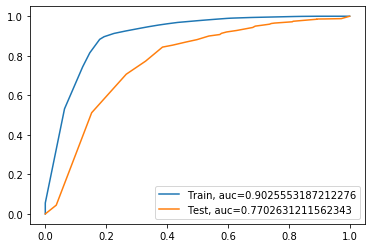

In [43]:
#Plotting the ROC curve for Decision Tree
best_model.fit(X_aw2v_tr, y_aw2v_tr)

y_pred_tr = best_model.predict_proba(X_aw2v_tr)[::,1]
y_pred_te = best_model.predict_proba(X_aw2v_te)[::,1]
fpr_tr, tpr_tr, _tr = metrics.roc_curve(y_aw2v_tr,  y_pred_tr)
fpr_te, tpr_te, _te = metrics.roc_curve(y_aw2v_te,  y_pred_te)
auc_tr_aw_dt = metrics.roc_auc_score(y_aw2v_tr, y_pred_tr)
auc_te_aw_dt = metrics.roc_auc_score(y_aw2v_te, y_pred_te)
plt.plot(fpr_tr,tpr_tr,label="Train, auc="+str(auc_tr_aw_dt))
plt.plot(fpr_te,tpr_te,label="Test, auc="+str(auc_te_aw_dt))
plt.legend(loc=4)
plt.show()

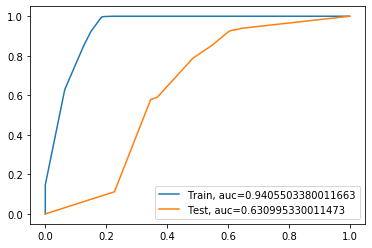

In [53]:
#Plotting the ROC curve for Decision Tree
clf = DecisionTreeClassifier(max_depth = 10, min_samples_split = 5)
clf.fit(X_aw2v_tr, y_aw2v_tr)

y_pred_tr = clf.predict_proba(X_aw2v_tr)[::,1]
y_pred_te = clf.predict_proba(X_aw2v_te)[::,1]
fpr_tr, tpr_tr, _tr = metrics.roc_curve(y_aw2v_tr,  y_pred_tr)
fpr_te, tpr_te, _te = metrics.roc_curve(y_aw2v_te,  y_pred_te)
auc_tr_aw_dt2 = metrics.roc_auc_score(y_aw2v_tr, y_pred_tr)
auc_te_aw_dt2 = metrics.roc_auc_score(y_aw2v_te, y_pred_te)
plt.plot(fpr_tr,tpr_tr,label="Train, auc="+str(auc_tr_aw_dt2))
plt.plot(fpr_te,tpr_te,label="Test, auc="+str(auc_te_aw_dt2))
plt.legend(loc=4)
plt.show()

# 4. TF-IDF WEIGHTED WORD2VEC

In [44]:
model = TfidfVectorizer()
#model.fit(preprocessed_reviews[0:5000])
model.fit(preprocessed_reviews[:10000])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [45]:
len(dictionary)

21580

In [46]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(300) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [13:51<00:00, 12.03it/s]


In [47]:
model = TfidfVectorizer()
model.fit(preprocessed_summaries[0:10000])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [48]:
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sum_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(summary_list): # for each review/sentence 
    sent_vec = np.zeros(300) # as word vectors are of zero length
    weight_sum = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sum_vectors.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:22<00:00, 121.00it/s]


In [49]:
tsev = np.asarray(tfidf_sent_vectors)
tsuv = np.asarray(tfidf_sum_vectors)
print(sev.shape, suv.shape)

(10000, 300) (10000, 300)


In [50]:
y = Y[:10000]
print(y.value_counts())
X_tw2v = (np.vstack((tsev.T, tsuv.T))).T
print(X_aw2v.shape)
X_tw2v_1, X_tw2v_te, y_tw2v_1, y_tw2v_te = train_test_split(X_tw2v, y, test_size = 0.3, random_state = 0)
X_tw2v_tr, X_tw2v_cv, y_tw2v_tr, y_tw2v_cv = train_test_split(X_tw2v_1, y_tw2v_1, test_size = 0.3, random_state = 0)

1    8868
0    1132
Name: Score, dtype: int64
(10000, 600)


In [76]:
#Manually searching for best hyperparameter using KNN
from sklearn.metrics import accuracy_score
ks = [1, 3, 5, 9, 13, 19, 25, 35, 50]
for k in tqdm(ks):
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(X_tw2v_tr, y_tw2v_tr)
    
    y_pred_tr = clf.predict(X_tw2v_tr)
    y_pred_cv = clf.predict(X_tw2v_cv)
    
    tr_acc = accuracy_score(y_tw2v_tr, y_pred_tr)
    cv_acc = accuracy_score(y_tw2v_cv, y_pred_cv)
    
    print("The accuracy for" + str(k) + "nearest neighbors is:" +str(tr_acc)+"for train and" + str(cv_acc) +"for cv")

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

The accuracy for1nearest neighbors is:1.0for train and0.8904761904761904for cv


 11%|█████████▎                                                                          | 1/9 [00:10<01:26, 10.86s/it]

The accuracy for3nearest neighbors is:0.9359183673469388for train and0.9004761904761904for cv


 22%|██████████████████▋                                                                 | 2/9 [00:45<02:06, 18.02s/it]

The accuracy for5nearest neighbors is:0.9236734693877551for train and0.910952380952381for cv


 33%|████████████████████████████                                                        | 3/9 [01:20<02:18, 23.10s/it]

The accuracy for9nearest neighbors is:0.9108163265306123for train and0.9071428571428571for cv


 44%|█████████████████████████████████████▎                                              | 4/9 [01:55<02:13, 26.66s/it]

The accuracy for13nearest neighbors is:0.9038775510204081for train and0.9047619047619048for cv


 56%|██████████████████████████████████████████████▋                                     | 5/9 [02:30<01:56, 29.21s/it]

The accuracy for19nearest neighbors is:0.8973469387755102for train and0.9052380952380953for cv


 67%|████████████████████████████████████████████████████████                            | 6/9 [03:05<01:32, 30.96s/it]

The accuracy for25nearest neighbors is:0.8938775510204081for train and0.9014285714285715for cv


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [03:40<01:04, 32.23s/it]

The accuracy for35nearest neighbors is:0.8922448979591837for train and0.9014285714285715for cv


 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [04:16<00:33, 33.11s/it]

The accuracy for50nearest neighbors is:0.8918367346938776for train and0.9for cv


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [04:51<00:00, 33.71s/it]


In [120]:
#Hyperparamter tuning for KNN
from sklearn.model_selection import GridSearchCV
gsc = GridSearchCV(
        estimator = KNeighborsClassifier(),
        param_grid = {
            'n_neighbors': [1, 3, 5, 9, 13, 19, 25, 35, 50]
        }, cv = 3, scoring = 'roc_auc', verbose = 10)

grid_result = gsc.fit(X_tw2v_tr, y_tw2v_tr)
best_params = grid_result.best_params_
print(best_params)
print(gsc.score(X_tw2v_tr, y_tw2v_tr))
best_model = KNeighborsClassifier(n_neighbors = best_params['n_neighbors'])

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] n_neighbors=1 ...................................................
[CV] ....................... n_neighbors=1, score=0.634, total=   5.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s


[CV] n_neighbors=1 ...................................................
[CV] ....................... n_neighbors=1, score=0.682, total=   5.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.0s remaining:    0.0s


[CV] n_neighbors=1 ...................................................
[CV] ....................... n_neighbors=1, score=0.648, total=   4.9s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.9s remaining:    0.0s


[CV] n_neighbors=3 ...................................................
[CV] ....................... n_neighbors=3, score=0.662, total=   4.8s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   19.7s remaining:    0.0s


[CV] n_neighbors=3 ...................................................
[CV] ....................... n_neighbors=3, score=0.768, total=   4.7s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.4s remaining:    0.0s


[CV] n_neighbors=3 ...................................................
[CV] ....................... n_neighbors=3, score=0.718, total=   4.8s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   29.2s remaining:    0.0s


[CV] n_neighbors=5 ...................................................
[CV] ....................... n_neighbors=5, score=0.703, total=   4.9s


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   34.1s remaining:    0.0s


[CV] n_neighbors=5 ...................................................
[CV] ....................... n_neighbors=5, score=0.793, total=   4.8s


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   38.9s remaining:    0.0s


[CV] n_neighbors=5 ...................................................
[CV] ....................... n_neighbors=5, score=0.760, total=   4.9s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   43.8s remaining:    0.0s


[CV] n_neighbors=9 ...................................................
[CV] ....................... n_neighbors=9, score=0.727, total=   4.9s
[CV] n_neighbors=9 ...................................................
[CV] ....................... n_neighbors=9, score=0.819, total=   5.2s
[CV] n_neighbors=9 ...................................................
[CV] ....................... n_neighbors=9, score=0.787, total=   5.1s
[CV] n_neighbors=13 ..................................................
[CV] ...................... n_neighbors=13, score=0.750, total=   5.0s
[CV] n_neighbors=13 ..................................................
[CV] ...................... n_neighbors=13, score=0.832, total=   5.0s
[CV] n_neighbors=13 ..................................................
[CV] ...................... n_neighbors=13, score=0.793, total=   4.8s
[CV] n_neighbors=19 ..................................................
[CV] ...................... n_neighbors=19, score=0.779, total=   4.8s
[CV] n

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  2.2min finished


{'n_neighbors': 50}
0.8912845290328797


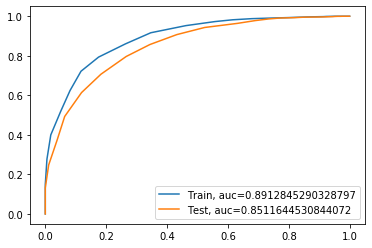

In [122]:
#Plotting the ROC curve for KNN
best_model.fit(X_tw2v_tr, y_tw2v_tr)

y_pred_tr = best_model.predict_proba(X_tw2v_tr)[::,1]
y_pred_te = best_model.predict_proba(X_tw2v_te)[::,1]
fpr_tr, tpr_tr, _tr = metrics.roc_curve(y_tw2v_tr,  y_pred_tr)
fpr_te, tpr_te, _te = metrics.roc_curve(y_tw2v_te,  y_pred_te)
auc_tr_tw_knn = metrics.roc_auc_score(y_tw2v_tr, y_pred_tr)
auc_te_tw_knn = metrics.roc_auc_score(y_tw2v_te, y_pred_te)
plt.plot(fpr_tr,tpr_tr,label="Train, auc="+str(auc_tr_tw_knn))
plt.plot(fpr_te,tpr_te,label="Test, auc="+str(auc_te_tw_knn))
plt.legend(loc=4)
plt.show()

In [79]:
#Application of Naive Bayes
from sklearn.metrics import accuracy_score
A = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
for a in A:
    clf = MultinomialNB(alpha = a)
    clf.fit(X_tw2v_tr, y_tw2v_tr)
    
    y_pred_tr = clf.predict(X_tw2v_tr)
    y_pred_cv = clf.predict(X_tw2v_cv)
    
    tr_acc = accuracy_score(y_tw2v_tr, y_pred_tr)
    cv_acc = accuracy_score(y_tw2v_cv, y_pred_cv)
    
    print("The accuracy for value of alpha: " + str(a)+" is " +str(tr_acc)+" for train and " + str(cv_acc) +"for cv")

ValueError: Input X must be non-negative

In [80]:
#Hyperparamter tuning for logistic regression
gsc = GridSearchCV(
    estimator = SGDClassifier(loss = 'log'), 
    param_grid = {
        'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
    }, cv = 5, scoring='roc_auc', verbose=10, n_jobs=-1)

grid_result = gsc.fit(X_tw2v_tr, y_tw2v_tr)
best_params = grid_result.best_params_
print(best_params)
print(gsc.score(X_tw2v_tr, y_tw2v_tr))
best_model = SGDClassifier(loss = 'log', alpha = best_params['alpha'])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  27 out of  45 | elapsed:    3.2s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  32 out of  45 | elapsed:    3.4s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  37 out of  45 | elapsed:    3.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  42 out of  45 | elapsed:    3.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.6s finished


{'alpha': 0.001}
0.9472987318933881


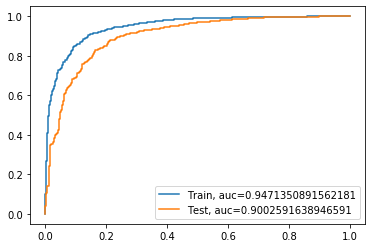

In [81]:
#Roc curve using logistic regression
#Code taken from https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python
best_model.fit(X_tw2v_tr, y_tw2v_tr)

y_pred_tr = best_model.predict_proba(X_tw2v_tr)[::,1]
y_pred_te = best_model.predict_proba(X_tw2v_te)[::,1]
fpr_tr, tpr_tr, _tr = metrics.roc_curve(y_tw2v_tr,  y_pred_tr)
fpr_te, tpr_te, _te = metrics.roc_curve(y_tw2v_te,  y_pred_te)
auc_tr_tw_lr = metrics.roc_auc_score(y_tw2v_tr, y_pred_tr)
auc_te_tw_lr = metrics.roc_auc_score(y_tw2v_te, y_pred_te)
plt.plot(fpr_tr,tpr_tr,label="Train, auc="+str(auc_tr_tw_lr))
plt.plot(fpr_te,tpr_te,label="Test, auc="+str(auc_te_tw_lr))
plt.legend(loc=4)
plt.show()

In [82]:
#Hpyerparamter tuning for SVM
gsc = GridSearchCV(
    estimator = SGDClassifier(loss = 'hinge'), 
    param_grid = {
        'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
    }, cv = 5, scoring='roc_auc', verbose=10, n_jobs=-1)

grid_result = gsc.fit(X_tw2v_tr, y_tw2v_tr)
best_params = grid_result.best_params_
print(best_params)
print(gsc.score(X_tw2v_tr, y_tw2v_tr))
best_model = SGDClassifier(loss = 'hinge', alpha = best_params['alpha'])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  27 out of  45 | elapsed:    1.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  32 out of  45 | elapsed:    1.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  37 out of  45 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  42 out of  45 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


{'alpha': 0.001}
0.9547291089694495


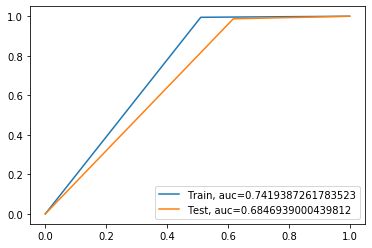

In [83]:
#Roc curve using SVM
#Code taken from https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python
best_model.fit(X_tw2v_tr, y_tw2v_tr)

y_pred_tr = best_model.predict(X_tw2v_tr)
y_pred_te = best_model.predict(X_tw2v_te)
fpr_tr, tpr_tr, _tr = metrics.roc_curve(y_tw2v_tr,  y_pred_tr)
fpr_te, tpr_te, _te = metrics.roc_curve(y_tw2v_te,  y_pred_te)
auc_tr_tw_svm = metrics.roc_auc_score(y_tw2v_tr, y_pred_tr)
auc_te_tw_svm = metrics.roc_auc_score(y_tw2v_te, y_pred_te)
plt.plot(fpr_tr,tpr_tr,label="Train, auc="+str(auc_tr_tw_svm))
plt.plot(fpr_te,tpr_te,label="Test, auc="+str(auc_te_tw_svm))
plt.legend(loc=4)
plt.show()

In [51]:
#Hyperparamter tuning with decision trees
gsc = GridSearchCV(
    estimator = DecisionTreeClassifier(), 
    param_grid = {
        'max_depth': [2, 5, 10, 20, 50],
        'min_samples_split': [5, 10, 20, 30, 50, 100]
    }, cv = 5, scoring='roc_auc', verbose=10, n_jobs=-1)

grid_result = gsc.fit(X_tw2v_tr, y_tw2v_tr)
best_params = grid_result.best_params_
print(best_params)
print(gsc.score(X_tw2v_tr, y_tw2v_tr))
best_model = DecisionTreeClassifier(max_depth = best_params['max_depth'], min_samples_split = best_params['min_samples_split'])

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 143 out of 150 | elapsed:   50.4s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   53.8s finished


{'max_depth': 5, 'min_samples_split': 50}
0.7812003153237717


In [85]:
#Manual search for best hyperparamter using Decision trees
D = [2, 5, 10, 20, 50]
MSS = [5, 10, 20, 30, 50, 100]
for d in tqdm(D):
    for m in MSS:
        clf = DecisionTreeClassifier(max_depth = d, min_samples_split = m)
        clf.fit(X_tw2v_tr, y_tw2v_tr)

        y_pred_tr = clf.predict(X_tw2v_tr)
        y_pred_cv = clf.predict(X_tw2v_cv)

        tr_acc = accuracy_score(y_tw2v_tr, y_pred_tr)
        cv_acc = accuracy_score(y_tw2v_cv, y_pred_cv)
    
        print("The accuracy for value of depth: " + str(d)+" and min samples split: " + str(m) +" is " +str(tr_acc)+" for train and " + str(cv_acc) +" for cv")

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

The accuracy for value of depth: 2 and min samples split: 5 is 0.8928571428571429 for train and 0.8952380952380953 for cv
The accuracy for value of depth: 2 and min samples split: 10 is 0.8928571428571429 for train and 0.8952380952380953 for cv
The accuracy for value of depth: 2 and min samples split: 20 is 0.8928571428571429 for train and 0.8952380952380953 for cv
The accuracy for value of depth: 2 and min samples split: 30 is 0.8928571428571429 for train and 0.8952380952380953 for cv
The accuracy for value of depth: 2 and min samples split: 50 is 0.8928571428571429 for train and 0.8952380952380953 for cv
The accuracy for value of depth: 2 and min samples split: 100 is 0.8928571428571429 for train and 0.8952380952380953 for cv


 20%|████████████████▊                                                                   | 1/5 [00:03<00:12,  3.15s/it]

The accuracy for value of depth: 5 and min samples split: 5 is 0.9104081632653062 for train and 0.8957142857142857 for cv
The accuracy for value of depth: 5 and min samples split: 10 is 0.91 for train and 0.8966666666666666 for cv
The accuracy for value of depth: 5 and min samples split: 20 is 0.9089795918367347 for train and 0.8966666666666666 for cv
The accuracy for value of depth: 5 and min samples split: 30 is 0.9057142857142857 for train and 0.8909523809523809 for cv
The accuracy for value of depth: 5 and min samples split: 50 is 0.9044897959183673 for train and 0.8909523809523809 for cv
The accuracy for value of depth: 5 and min samples split: 100 is 0.9026530612244898 for train and 0.8876190476190476 for cv


 40%|█████████████████████████████████▌                                                  | 2/5 [00:10<00:13,  4.54s/it]

The accuracy for value of depth: 10 and min samples split: 5 is 0.9542857142857143 for train and 0.8842857142857142 for cv
The accuracy for value of depth: 10 and min samples split: 10 is 0.9520408163265306 for train and 0.8828571428571429 for cv
The accuracy for value of depth: 10 and min samples split: 20 is 0.9440816326530612 for train and 0.8838095238095238 for cv
The accuracy for value of depth: 10 and min samples split: 30 is 0.936530612244898 for train and 0.8723809523809524 for cv
The accuracy for value of depth: 10 and min samples split: 50 is 0.926734693877551 for train and 0.8742857142857143 for cv
The accuracy for value of depth: 10 and min samples split: 100 is 0.9151020408163265 for train and 0.8690476190476191 for cv


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:24<00:14,  7.21s/it]

The accuracy for value of depth: 20 and min samples split: 5 is 0.9838775510204082 for train and 0.8652380952380953 for cv
The accuracy for value of depth: 20 and min samples split: 10 is 0.976938775510204 for train and 0.8495238095238096 for cv
The accuracy for value of depth: 20 and min samples split: 20 is 0.9614285714285714 for train and 0.86 for cv
The accuracy for value of depth: 20 and min samples split: 30 is 0.9506122448979591 for train and 0.8485714285714285 for cv
The accuracy for value of depth: 20 and min samples split: 50 is 0.94 for train and 0.8480952380952381 for cv
The accuracy for value of depth: 20 and min samples split: 100 is 0.9230612244897959 for train and 0.8561904761904762 for cv


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:47<00:11, 12.00s/it]

The accuracy for value of depth: 50 and min samples split: 5 is 0.9948979591836735 for train and 0.8461904761904762 for cv
The accuracy for value of depth: 50 and min samples split: 10 is 0.9834693877551021 for train and 0.8519047619047619 for cv
The accuracy for value of depth: 50 and min samples split: 20 is 0.9655102040816327 for train and 0.8523809523809524 for cv
The accuracy for value of depth: 50 and min samples split: 30 is 0.9557142857142857 for train and 0.8442857142857143 for cv
The accuracy for value of depth: 50 and min samples split: 50 is 0.9420408163265306 for train and 0.8466666666666667 for cv
The accuracy for value of depth: 50 and min samples split: 100 is 0.9261224489795918 for train and 0.8504761904761905 for cv


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:23<00:00, 19.15s/it]


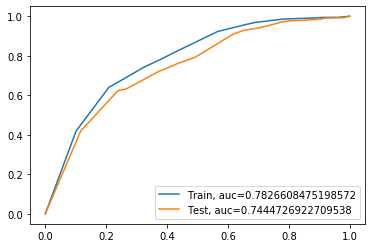

In [52]:
#Plotting the ROC curve for Decision Tree
best_model.fit(X_aw2v_tr, y_aw2v_tr)

y_pred_tr = best_model.predict_proba(X_tw2v_tr)[::, 1]
y_pred_te = best_model.predict_proba(X_tw2v_te)[::, 1]
fpr_tr, tpr_tr, _tr = metrics.roc_curve(y_tw2v_tr,  y_pred_tr)
fpr_te, tpr_te, _te = metrics.roc_curve(y_tw2v_te,  y_pred_te)
auc_tr_tw_dt = metrics.roc_auc_score(y_tw2v_tr, y_pred_tr)
auc_te_tw_dt = metrics.roc_auc_score(y_tw2v_te, y_pred_te)
plt.plot(fpr_tr,tpr_tr,label="Train, auc="+str(auc_tr_tw_dt))
plt.plot(fpr_te,tpr_te,label="Test, auc="+str(auc_te_tw_dt))
plt.legend(loc=4)
plt.show()